# Workflow to compare time-series properties from simulated and empirical data with those obtained from surrogates

This notebook introduces a proposed workflow for computing the catch24 feature set (catch22 + mean + SD) from a given time-series dataset and comparing the results with features computed on a surrogate of the original time series.

In [12]:
# Load required libraries 
import pyunicorn.timeseries.surrogates as tsu
import numpy as np
import pandas as pd
import pycatch22 as c22
import os
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline

### Define classification parameters


In [13]:
# Define linear SVM classifier pipeline
model = svm.SVC(C=1, class_weight='balanced', kernel='linear', random_state=127, probability=True)
pipe = Pipeline([('scaler', StandardScaler()), 
                            ('model', model)])

# Define scoring type
scoring = {'accuracy': 'accuracy',
           'balanced_accuracy': 'balanced_accuracy'}

# Define ten-fold cross-validation splitter
num_folds = 10
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=127)

In [14]:
# Helper function to generate surrogates from a given time series with three methods:
# 1. Shuffle
# 2. Phase randomization with a fast Fourier transform (FFT)
# 3. Phase randomization with an iterative amplitude adjusted Fourier transform (IAAFT)
def surrogate(x, tag, niters=20):
    ts = x.reshape(1, len(x))
    surr = tsu.Surrogates(ts)
    if tag.lower() == "shuffle":
        return surr.white_noise_surrogates()
    elif tag.lower() == "fft":
        return surr.correlated_noise_surrogates()
    elif tag.lower() == "iafft":
        return surr.refined_AAFT_surrogates(niters)

# Define our surrogate methods
surrogate_methods = ["shuffle", "fft", "iafft"]
    
def apply_surrogate_to_data(problem_data, name, data_path, surrogate_methods, overwrite=False):
    if not os.path.exists(f"{data_path}/real/surrogate_TS/{name}_TS_surrogates.csv") or overwrite:
        # Initialize list to store surrogate data
        problem_surrogates_list = []

        ids = problem_data["id"].unique()

        # Iterate over the IDs
        for i in ids:
            print(f"Generating surrogates for {name} ID {i}")
            # Extract time-series data for this ID
            x = problem_data.sort_values('timepoint').query("id==@i")['values'].values

            # Extract the number part of the ID
            i_num = i.split("_")[0]

            # Initialize array to save surrogates
            x_surr = np.zeros((len(x), len(surrogate_methods)+1))

            # First column is the original time series
            x_surr[:, 0] = x

            # Iterate over each surrogate method to generate
            for m in range(len(surrogate_methods)):
                x_surr[:, m+1] = surrogate(x, surrogate_methods[m]).flatten()
            
            # Create dataframe for this ID
            ID_surrogates_df = pd.DataFrame(x_surr, columns=["original"] + surrogate_methods).assign(id = i_num, problem = name)

            # Append to the list of surrogates
            problem_surrogates_list.append(ID_surrogates_df)

        # Concatenate all surrogates for this problem
        problem_surrogates_df = pd.concat(problem_surrogates_list)

        # Save the surrogates to a CSV file
        problem_surrogates_df.to_csv(f"{data_path}/real/surrogate_TS/{name}_TS_surrogates.csv", index=False)
        
def apply_catch24_to_TS_and_surrogate(name, data_path, surrogate_methods, overwrite=False):
    if not os.path.exists(f"{data_path}/real/catch24_res/{name}_catch24_TS_surrogates.csv") or overwrite:
        # Load the time series and surrogate data
        problem_TS_df = pd.read_csv(f"{data_path}/real/preprocessed_TS/{name}_TS.csv")
        problem_surrogates_df = pd.read_csv(f"{data_path}/real/surrogate_TS/{name}_TS_surrogates.csv")

        # Create list to save catch24 results for this problem
        problem_catch24_res_list = []

        # Get unique IDs
        ids = problem_TS_df["id"].unique()

        for i in ids:
            id_num = int(i.split("_")[0])

            id_catch24_res = np.zeros((24, 4))

            # Extract 'target' column for this ID
            group = problem_TS_df.query("id==@i")['target'].unique()[0]

            # Run catch22 plus mean/SD for real data
            x = problem_TS_df.query("id==@i")['values'].values

            # Check for any NaNs 
            if np.isnan(x).any():
                print(f"NaNs found in {name} ID {i}, skipping")
                continue
            x_catch24_res = c22.catch22_all(x, catch24=True)

            # Add values to first column of id_catch24_res
            id_catch24_res[:, 0] = x_catch24_res['values']

            catch24_features = x_catch24_res['names']

            # Also iterate over each surrogate method
            for sur_ind in range(len(surrogate_methods)):
                surrogate_method = surrogate_methods[sur_ind]
                x_sur = problem_surrogates_df.query("id==@id_num")[surrogate_method].values

                # Run catch22 plus mean/SD
                x_sur_catch24_res = c22.catch22_all(x_sur, catch24=True)

                # Add values to the m+1 column of id_catch24_res
                id_catch24_res[:, sur_ind+1] = x_sur_catch24_res['values']

            # Convert id_catch24_res to a dataframe
            id_catch24_res_df = pd.DataFrame(id_catch24_res, columns=["real"] + surrogate_methods).assign(id=id_num, group=group, names=catch24_features, problem=name)

            problem_catch24_res_list.append(id_catch24_res_df)

        # Concatenate all catch24 results for this problem
        problem_catch24_res_df = pd.concat(problem_catch24_res_list)

        # Save the catch24 results to a CSV file
        problem_catch24_res_df.to_csv(f"{data_path}/real/catch24_res/{name}_catch24_TS_surrogates.csv", index=False)

def fit_classifier_to_catch24_res(name, data_path, pipe, cv, scoring, surrogate_methods, overwrite=False):
    if not os.path.exists(f"{data_path}/real/classification_res/{name}_catch24_TS_and_surrogates_classification_res.csv") or overwrite:
        problem_catch24_res = pd.read_csv(f"{data_path}/real/catch24_res/{name}_catch24_TS_surrogates.csv")

        # Initialize list to store results
        problem_catch24_classification_res_list = []

        # Pivot the 'real' data first
        problem_catch24_TS_res_wide = problem_catch24_res.pivot(index=["id", "group"], columns="names", values="real")

        # Extract just the values
        problem_catch24_TS_res_wide_values = problem_catch24_TS_res_wide.values

        # Extract the group labels
        group_labels = problem_catch24_TS_res_wide.index.get_level_values("group").values

        # Compute cross-validated accuracy and balanced accuracy for the original time series
        cv_original_TS_catch24 = cross_validate(pipe, problem_catch24_TS_res_wide_values, group_labels, cv=cv, scoring=scoring)
        cv_original_TS_catch24_df = pd.DataFrame({"Problem": name,
                                                "TS_Type": "original",
                                                "Feature_Set": "catch24",
                                                "Fold_Number": np.arange(1, num_folds+1),
                                                "accuracy": cv_original_TS_catch24["test_accuracy"],
                                                "balanced_accuracy": cv_original_TS_catch24["test_balanced_accuracy"]})

        # Append to the list of results
        problem_catch24_classification_res_list.append(cv_original_TS_catch24_df)

        # Iterate over results for 'real' and each surrogate method
        for surrogate_method in surrogate_methods:

            # Pivot the surrogate catch24 results
            problem_catch24_surrogate_res_wide = problem_catch24_res.pivot(index=["id", "group"], columns="names", values=surrogate_method)

            # Extract just the values
            problem_catch24_surrogate_res_wide_values = problem_catch24_surrogate_res_wide.values

            # Compute cross-validated accuracy and balanced accuracy for the original time series
            cv_surrogate_method_TS_catch24 = cross_validate(pipe, problem_catch24_surrogate_res_wide_values, group_labels, cv=cv, scoring=scoring)
            cv_surrogate_method_TS_catch24_df = pd.DataFrame({"Problem": name,
                                                    "TS_Type": surrogate_method,
                                                    "Feature_Set": "catch24",
                                                    "Fold_Number": np.arange(1, num_folds+1),
                                                    "accuracy": cv_surrogate_method_TS_catch24["test_accuracy"],
                                                    "balanced_accuracy": cv_surrogate_method_TS_catch24["test_balanced_accuracy"]})
            
            # Append to the list of results
            problem_catch24_classification_res_list.append(cv_surrogate_method_TS_catch24_df)

        # Concatenate all results
        problem_catch24_classification_res_df = pd.concat(problem_catch24_classification_res_list)

        # Save the results to a CSV file
        problem_catch24_classification_res_df.to_csv(f"{data_path}/real/classification_res/{name}_catch24_TS_and_surrogates_classification_res.csv", index=False)


### Compute the three surrogate methods for each of the empirical time-series classification datasets

In [15]:
# * Loop over the datasets, reading names from preprocessed_TS folder
data_path = os.getcwd()

names = os.listdir("real/preprocessed_TS")
names = [name.split("_TS")[0] for name in names]
for name in names:

    # * Load preprocessed data matrix
    problem_data = pd.read_csv(f"{data_path}/real/preprocessed_TS/{name}_TS.csv")
    ids = problem_data["id"].unique()

    # Compute surrogates for this problem
    print(f"Generating surrogates for {name}")
    apply_surrogate_to_data(problem_data, name, data_path, surrogate_methods)

    # Apply catch24 to real and surrogate data
    print(f"Computing catch24 features for {name} real and surrogate data")
    apply_catch24_to_TS_and_surrogate(name, data_path, surrogate_methods)

    # Fit classifier to catch24 features
    print(f"Fitting classifier to catch24 features for {name}")
    fit_classifier_to_catch24_res(name, data_path, pipe, cv, scoring, surrogate_methods)
    


Generating surrogates for InsectEPGRegularTrain
Computing catch24 features for InsectEPGRegularTrain real and surrogate data
Fitting classifier to catch24 features for InsectEPGRegularTrain
Generating surrogates for Beef
Computing catch24 features for Beef real and surrogate data
Fitting classifier to catch24 features for Beef
Generating surrogates for GunPointOldVersusYoung
Computing catch24 features for GunPointOldVersusYoung real and surrogate data
Fitting classifier to catch24 features for GunPointOldVersusYoung
Generating surrogates for Wafer
Computing catch24 features for Wafer real and surrogate data
Fitting classifier to catch24 features for Wafer
Generating surrogates for InlineSkate
Computing catch24 features for InlineSkate real and surrogate data
Fitting classifier to catch24 features for InlineSkate
Generating surrogates for DodgerLoopWeekend
Computing catch24 features for DodgerLoopWeekend real and surrogate data
Fitting classifier to catch24 features for DodgerLoopWeeken

In [18]:
problem_catch24_classification_res_df.head()

,Problem,TS_Type,Feature_Set,Fold_Number,accuracy,balanced_accuracy
0,InsectEPGRegularTrain,original,catch24,1,1.0,1.0
1,InsectEPGRegularTrain,original,catch24,2,1.0,1.0
2,InsectEPGRegularTrain,original,catch24,3,1.0,1.0
3,InsectEPGRegularTrain,original,catch24,4,1.0,1.0
4,InsectEPGRegularTrain,original,catch24,5,1.0,1.0


### Visualizations [using R functionality]

In [25]:
all_catch24_classification_res_list = [pd.read_csv(f"{data_path}/real/classification_res/{name}_catch24_TS_and_surrogates_classification_res.csv") for name in names]
all_catch24_classification_res = pd.concat(all_catch24_classification_res_list).reset_index()

%load_ext rpy2.ipython

all_catch24_classification_res.head()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


,index,Problem,TS_Type,Feature_Set,Fold_Number,accuracy,balanced_accuracy
0,0,InsectEPGRegularTrain,original,catch24,1,1.0,1.0
1,1,InsectEPGRegularTrain,original,catch24,2,1.0,1.0
2,2,InsectEPGRegularTrain,original,catch24,3,1.0,1.0
3,3,InsectEPGRegularTrain,original,catch24,4,1.0,1.0
4,4,InsectEPGRegularTrain,original,catch24,5,1.0,1.0


`summarise()` has grouped output by 'Problem'. You can override using the
`.groups` argument.


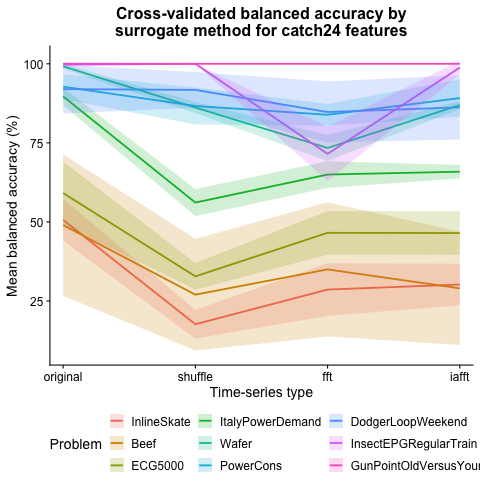

In [46]:
%%R -i all_catch24_classification_res,data_path

suppressPackageStartupMessages({
    library(cowplot)
    library(glue)
    library(patchwork)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())


all_catch24_classification_res %>%
    mutate(TS_Type = factor(TS_Type, levels=c("original", "shuffle", "fft", "iafft"))) %>%
    group_by(Problem, TS_Type) %>%
    summarize(mean_balanced_accuracy = 100*mean(balanced_accuracy), SD_balanced_accuracy = 100*sd(balanced_accuracy)) %>%
    ungroup() %>%
    mutate(Problem = fct_reorder(Problem, mean_balanced_accuracy, .fun=mean)) %>%
    ggplot(data=., mapping=aes(x=TS_Type, y=mean_balanced_accuracy, group=Problem)) +
    geom_line(aes(color=Problem), linewidth=0.85) +
    geom_ribbon(aes(ymin=mean_balanced_accuracy-SD_balanced_accuracy, 
                    ymax=mean_balanced_accuracy+SD_balanced_accuracy, 
                    fill=Problem), color=NA, alpha=0.2) +
    ggtitle("Cross-validated balanced accuracy by\nsurrogate method for catch24 features") +
    ylab("Mean balanced accuracy (%)") +
    xlab("Time-series type") +
    scale_x_discrete(expand=c(0.025, 0.025)) +
    guides(color=guide_legend(nrow=3),fill=guide_legend(nrow=3)) +
    theme(legend.position="bottom",
          plot.title=element_text(hjust=0.5))

# Uncomment to save the plot
# ggsave(glue("{data_path}/plots/catch24_surrogate_classification_res.png"), width=7, height=6, dpi=300)